In [1]:
import sys
sys.path.append('../')
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np

import argparse

import os

from PIL import Image
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray


import pandas as pd

In [2]:
parser = argparse.ArgumentParser()


parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="SkyData",help='SkyData')


parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=6, help='epoch_load_one')

parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=6, help='epoch_load_two')

parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=6, help='epoch_load_three')


parser.add_argument('--num_iters', action="store", dest="num_iters", type=int, default=10,help='num_iters')
parser.add_argument('--samples_to_test', action="store", dest="samples_to_test", type=int, default=10,help='samples to test')


parser.add_argument('--feature_map_type', action="store", dest="feature_map_type", default='special',help='regular or special')

parser.add_argument('--initial_type', action="store", dest="initial_type", default='vanilla',help='vanilla, simple_net, multi_net')

parser.add_argument('--load_epoch_simplenet', action="store", dest="load_epoch_simplenet", default=50,help='load_epoch_simplenet')

parser.add_argument('--load_epoch_multinet', action="store", dest="load_epoch_multinet", default=[50,50,40],help='load_epoch_multinet')

input_parameters = parser.parse_args([])



In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)




1 Physical GPUs, 1 Logical GPUs


In [4]:
if not(os.path.exists('./results')):
    os.makedirs('./results')

In [5]:
def construct_matrix_regression(batch_size,network_output,network_output_2=[0]):
    extra=tf.ones((batch_size,1))
    predicted_matrix=tf.concat([network_output,extra],axis=-1)
    predicted_matrix=tf.reshape(predicted_matrix,[batch_size,3,3])
    if len(np.shape(network_output_2))>1:
        predicted_matrix_2=tf.concat([network_output_2,extra],axis=-1)
        predicted_matrix_2=tf.reshape(predicted_matrix_2,[batch_size,3,3])
    hh_matrix=[]
    for i in range(batch_size):
        if len(np.shape(network_output_2))>1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i,:,:],predicted_matrix[i,:,:])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i,:,:]))
        #hh_matrix.append(predicted_matrix[i,:,:])
    
    #return tf.linalg.inv(predicted_matrix+0.0001)
    return np.asarray(hh_matrix)


def initial_motion():
    # prepare source and target four points
    matrix_list=[]
    for i in range(1):
       
        src_points=[[0,0],[127,0],[127,127],[0,127]]

        tgt_points=[[32,32],[160,32],[160,160],[32,160]]

    
        src_points=np.reshape(src_points,[4,1,2])
        tgt_points=np.reshape(tgt_points,[4,1,2])

        # find homography
        h_matrix, status = cv2.findHomography(src_points, tgt_points,0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)


def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix



def average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    
    four_conner=[[top_left_u,top_left_v,1],[bottom_right_u,top_left_v,1],[bottom_right_u,bottom_right_v,1],[top_left_u,bottom_right_v,1]]
    four_conner=np.asarray(four_conner)
    four_conner=np.transpose(four_conner)
    four_conner=np.expand_dims(four_conner,axis=0)
    four_conner=np.tile(four_conner,[batch_size,1,1]).astype(np.float32)
    
    new_four_points=tf.matmul(predicted_matrix,four_conner)
    
    new_four_points_scale=new_four_points[:,2:,:]
    new_four_points= new_four_points/new_four_points_scale
    
    
    u_predict=new_four_points[:,0,:]
    v_predict=new_four_points[:,1,:]
    
    average_conner=tf.reduce_mean(tf.sqrt(tf.math.pow(u_predict-u_list,2)+tf.math.pow(v_predict-v_list,2)))
  
    
    return average_conner



def calculate_feature_map(input_tensor):
    bs,height,width,channel=tf.shape(input_tensor)
    path_extracted=tf.image.extract_patches(input_tensor, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding='SAME')
    path_extracted=tf.reshape(path_extracted,(bs,height,width,channel,9))
    path_extracted_mean=tf.math.reduce_mean(path_extracted,axis=3,keepdims=True)

    #path_extracted_mean=tf.tile(path_extracted_mean,[1,1,1,channel,1])
    path_extracted=path_extracted-path_extracted_mean
    path_extracted_transpose=tf.transpose(path_extracted,(0,1,2,4,3))
    variance_matrix=tf.matmul(path_extracted_transpose,path_extracted)
    
    tracevalue=tf.linalg.trace(variance_matrix)
    row_sum=tf.reduce_sum(variance_matrix,axis=-1)
    max_row_sum=tf.math.reduce_max(row_sum,axis=-1)
    min_row_sum=tf.math.reduce_min(row_sum,axis=-1)
    mimic_ratio=(max_row_sum+min_row_sum)/2.0/tracevalue
    
    return  tf.expand_dims(mimic_ratio,axis=-1)


In [6]:
import math

def augment_channels(img):
    #tt=np.zeros_like(img[:,:,:3])
    tt=img[:,:,:3]
    new_img=np.dstack((img[:,:,:3],np.repeat(tt, 2, axis=2)))
    new_img[:,:,0]=new_img[:,:,0]*0.3125 
    new_img[:,:,1]=new_img[:,:,1]*1
    new_img[:,:,2]=new_img[:,:,2]*0.7
    return new_img

def padImage(image,destShape):
    
    in_size=image.shape
    out_size=destShape
    
    channels=image.shape[2]
    
    

    padd_size=out_size[0]-in_size[0]
    left_top=math.ceil(padd_size/2)
    right_bottom=int(padd_size/2)
    
    
    paddedImage=np.array([np.pad(image[:,:,t],(left_top,right_bottom),'constant') for t in range(channels)])
    paddedImage=np.stack([t for t in paddedImage],axis=2)
    return paddedImage

def pileAndConcatenate(showcase):
    destSizeInput=showcase["input_fmap"]["input"].shape[1:]
    detSizeTemplate=showcase["template_fmap"]["template"].shape[1:]
    
    new_showcase={
           "sample":showcase["sample"],
           "input_fmap":{  
               
                "level_three":padImage(showcase["input_fmap"]["level_three"][0,:,:,:3],destSizeInput),
                "level_two":padImage(showcase["input_fmap"]["level_two"][0,:,:,:3],destSizeInput),
                "level_one":padImage(showcase["input_fmap"]["level_one"][0,:,:,:3],destSizeInput),
                "input":padImage(rgb2gray(showcase["input_fmap"]["input"][0,:,:,:3])[:,:,np.newaxis],destSizeInput)
            },
        
       

            "template_fmap":{
                
                "level_three":padImage(showcase["template_fmap"]["level_three"][0,:,:,:3],detSizeTemplate),
                "level_two":padImage(showcase["template_fmap"]["level_two"][0,:,:,:3],detSizeTemplate),
                "level_one":padImage(showcase["template_fmap"]["level_one"][0,:,:,:3],detSizeTemplate),
                "template":padImage(rgb2gray(showcase["template_fmap"]["template"][0,:,:,:3])[:,:,np.newaxis],detSizeTemplate)
            },
            "H":{
                "level_one":showcase["H"]["level_one"],
                "level_two":showcase["H"]["level_two"],
                "level_three":showcase["H"]["level_three"],
                "predicted":showcase["H"]["predicted"]
            },
            "UV":{
            "u_list":showcase["UV"]["u_list"],
            "v_list":showcase["UV"]["v_list"]

            }
        }
    
                
    
    return new_showcase


def detailAndLog(showcase):
    
    
    if not(os.path.exists('./results/fmaps')):
        print("creating one")
        os.makedirs('./results/fmaps')

#     new_showcase= pileAndConcatenate(showcase)
#     source=new_showcase["input_fmap"]
#     template=new_showcase["template_fmap"]
    

#     sourceInOne=np.hstack([source[k] for k in source.keys()])
#     templateInOne=np.hstack([template[k] for k in template.keys()]) 
    
#     fig, axe = plt.subplots(2, 1, figsize=(30,15))
    
# #     axe[0].imshow(Image.fromarray(img_as_ubyte(sourceInOne, 'RGB')))
# #     axe[1].imshow(Image.fromarray(img_as_ubyte(templateInOne, 'RGB')))
    
#     axe[0].imshow(sourceInOne.squeeze())
#     axe[1].imshow(templateInOne.squeeze())

    fig, axe = plt.subplots(2, 4, figsize=(35,20))

    axe[0][0].imshow(showcase["input_fmap"]["input"][0,:,:,:3])
    axe[0][1].imshow(showcase["input_fmap"]["level_one"][0,:,:,0])
    axe[0][2].imshow(showcase["input_fmap"]["level_two"][0,:,:,0])
    axe[0][3].imshow(showcase["input_fmap"]["level_three"][0,:,:,0])

    axe[1][0].imshow(showcase["template_fmap"]["template"][0,:,:,:3])
    axe[1][1].imshow(showcase["template_fmap"]["level_one"][0,:,:,0])
    axe[1][2].imshow(showcase["template_fmap"]["level_two"][0,:,:,0])
    axe[1][3].imshow(showcase["template_fmap"]["level_three"][0,:,:,0])



    
    plt.savefig(f"./results/fmaps/{showcase['sample']}.png")
    #plt.show()
    plt.close()
    print(f"------ : {showcase['sample']} ----- error : {showcase['corner_error']}")



In [7]:
def pileAndConcatenate2(showcase):
    destSizeInput=showcase["input_fmap"]["input"].shape[1:]
    detSizeTemplate=showcase["template_fmap"]["template"].shape[1:]
    
    new_showcase={
           "sample":showcase["sample"],
           "input_fmap":{  
               
                "level_three":augment_channels(padImage(showcase["input_fmap"]["level_three"][0,:,:,:3],destSizeInput)),
                "level_two":augment_channels(padImage(showcase["input_fmap"]["level_two"][0,:,:,:3],destSizeInput)),
                "level_one":augment_channels(padImage(showcase["input_fmap"]["level_one"][0,:,:,:3],destSizeInput)),
                "input":padImage(showcase["input_fmap"]["input"][0,:,:,:3],destSizeInput)
            },

            "template_fmap":{
                
                "level_three":augment_channels(padImage(showcase["template_fmap"]["level_three"][0,:,:,:3],detSizeTemplate)),
                "level_two":augment_channels(padImage(showcase["template_fmap"]["level_two"][0,:,:,:3],detSizeTemplate)),
                "level_one":augment_channels(padImage(showcase["template_fmap"]["level_one"][0,:,:,:3],detSizeTemplate)),
                "template":padImage(showcase["template_fmap"]["template"][0,:,:,:3],detSizeTemplate)
            },
            "H":{
                "level_one":showcase["H"]["level_one"],
                "level_two":showcase["H"]["level_two"],
                "level_three":showcase["H"]["level_three"],
                "predicted":showcase["H"]["predicted"]
            },
            "UV":{
            "u_list":showcase["UV"]["u_list"],
            "v_list":showcase["UV"]["v_list"]

            }
        }
    return new_showcase


In [8]:

from numpy.linalg import inv

def registerAndSave(new_showcase):
    predicted_H=new_showcase["H"]["predicted"]
    predicted_H=np.squeeze(predicted_H)

    template=new_showcase["template_fmap"]["template"]
    input=new_showcase["input_fmap"]["input"]

    #plt.imshow(input)
    #plt.show()

    warped=cv2.warpPerspective(template,np.squeeze(predicted_H),(192,192) )

    fused=(.4)*warped + 1*input
    #plt.imshow(fused)
    #plt.show()

    showcase["UV"]

    corners=[]


    for i,u in enumerate(new_showcase["UV"]["u_list"][0]):
        c=[u, new_showcase["UV"]["v_list"][0][i]]
        corners.append(c)

    src=[corners[0],corners[1],corners[3],corners[2]]

    src_points=src
    tgt_points=[[32,32],[159,32],[32,159],[159,159]]

    src_points=np.reshape(src_points,[4,1,2])
    tgt_points=np.reshape(tgt_points,[4,1,2])

    # find homography
    h1, status = cv2.findHomography(src_points, tgt_points,0)


    src_points=[[32,32],[159,32],[32,159],[159,159]]
    tgt_points=[[0,0],[127,0],[0,127],[127,127]]

    src_points=np.reshape(src_points,[4,1,2])
    tgt_points=np.reshape(tgt_points,[4,1,2])

    # find homography
    h2, status = cv2.findHomography(src_points, tgt_points,0)

    h=np.matmul(h2,h1)


    InverseH=inv(h)

    warpedgt=cv2.warpPerspective(template,np.squeeze(InverseH),(192,192) )


    fusedgt=(1)*warpedgt + 1*input
    fusedImg=np.hstack([fusedgt,fused])
    #plt.imshow(fusedImg)
    #plt.show()

    if not(os.path.exists('./results/registration')):
            print("creating one")
            os.makedirs('./results/registration/')
    fusedImg = cv2.convertScaleAbs(fusedImg, alpha=(255.0))
    fusedImg=fusedImg*255

    cv2.imwrite(f"./results/registration/registered-{new_showcase['sample']}.png", fusedImg)

In [9]:

if input_parameters.feature_map_type=='regular':
    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one_regular/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two_regular/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three_regular/'

    level_one_input=ResNet_first_input(if_regular=True)
    level_one_template=ResNet_first_template(if_regular=True)
    level_two_input=ResNet_second_input(if_regular=True)
    level_two_template=ResNet_second_template(if_regular=True)
    level_three_input=ResNet_third_input(if_regular=True)
    level_three_template=ResNet_third_template(if_regular=True)

elif input_parameters.feature_map_type=='special':

    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three/'

    level_one_input=ResNet_first_input()
    level_one_template=ResNet_first_template()
    level_two_input=ResNet_second_input()
    level_two_template=ResNet_second_template()
    level_three_input=ResNet_third_input()
    level_three_template=ResNet_third_template()


In [10]:


level_one_input.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"input_full")

level_one_template.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"template_full")

level_two_input.load_weights(load_path_two + 'epoch_'+str(input_parameters.epoch_load_two)+"input_full")

level_two_template.load_weights(load_path_two  + 'epoch_'+str(input_parameters.epoch_load_two)+"template_full")

level_three_input.load_weights(load_path_three + 'epoch_'+str(input_parameters.epoch_load_three)+"input_full")

level_three_template.load_weights(load_path_three  + 'epoch_'+str(input_parameters.epoch_load_three)+"template_full")


In [11]:
if input_parameters.initial_type=='vanilla':
    initial_matrix=initial_motion()
    initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)




LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=1)

LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=1)

LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=1)

LK_layer_regression=Lucas_Kanade_layer(batch_size=1,height_template=192,width_template=192,num_channels=3)




In [12]:
# showcase sample 10
showcase={
    "sample":0,
    
    "input_fmap":{
        "level_one":None,
        "level_two":None,
        "level_three":None,
        "input":None
    },
    
    "template_fmap":{
        "level_one":None,
        "level_two":None,
        "level_three":None,
        "template":None
    },
    "H":{
        "level_one":None,
        "level_two":None,
        "level_three":None,
        "predicted":None
    },
    "UV":{
        "u_list":None,
        "v_list":None
        
    },
    "corner_error":0
    
}

In [13]:

if input_parameters.dataset_name=='SkyData':
    data_loader_caller=data_loader_SkyData('val')

7990


In [14]:
file = open("./results/DLKFM_SkyData.txt","w") 

total_error=0.0    
fk_loop=input_parameters.num_iters
errors=[]
samples_to_test=input_parameters.samples_to_test
#samples_to_test=data_loader_caller.datasetSize()
for iters in range(samples_to_test):
    input_img,u_list,v_list,template_img=data_loader_caller.data_read_batch(batch_size=1)
    if len(np.shape(input_img))<2:
        break

        
        '''
        different net initializers
        VANILLA
        DHN
        MHN
        
        '''
        
    input_feature_one=level_one_input.call(input_img,training=False)
    template_feature_one=level_one_template.call(template_img,training=False)

    input_feature_two=level_two_input.call(input_feature_one,training=False)
    template_feature_two=level_two_template.call(template_feature_one,training=False)

    input_feature_three=level_three_input.call(input_feature_two,training=False)
    template_feature_three=level_three_template.call(template_feature_two,training=False)


    if input_parameters.feature_map_type=='regular':
        input_feature_map_one=input_feature_one
        template_feature_map_one=template_feature_one

        input_feature_map_two=input_feature_two
        template_feature_map_two=template_feature_two

        input_feature_map_three=input_feature_three
        template_feature_map_three=template_feature_three

    elif input_parameters.feature_map_type=='special':
                
        input_feature_map_one=calculate_feature_map(input_feature_one)
        template_feature_map_one=calculate_feature_map(template_feature_one)

        input_feature_map_two=calculate_feature_map(input_feature_two)
        template_feature_map_two=calculate_feature_map(template_feature_two)

        input_feature_map_three=calculate_feature_map(input_feature_three)
        template_feature_map_three=calculate_feature_map(template_feature_three)
        
    hh1=None
    hh2=None
    hh3=None    
    updated_matrix=initial_matrix
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_three.update_matrix(template_feature_map_three,input_feature_map_three,updated_matrix)
            h3=updated_matrix
        except:
            print ('s')

    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_two.update_matrix(template_feature_map_two,input_feature_map_two,updated_matrix)
            h2=updated_matrix
        except:
            print ('s')
            
    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_one.update_matrix(template_feature_map_one,input_feature_map_one,updated_matrix)
            h1=updated_matrix
        except:
                print ('s')



    predicted_matrix=updated_matrix
    cornner_error=average_cornner_error(1,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127)
    
    cornner_error=np.float(cornner_error)
    
    
    showcase={
        "sample":iters,

        "input_fmap":{
            "level_one":input_feature_map_one,
            "level_two":input_feature_map_two,
            "level_three":input_feature_map_three,
            "input":input_img
        },

        "template_fmap":{
            "level_one":template_feature_map_one,
            "level_two":template_feature_map_two,
            "level_three":template_feature_map_three,
            "template":template_img
        },
        "H":{
            "level_one":hh1,
            "level_two":hh2,
            "level_three":hh3,
            "predicted":predicted_matrix
        },
        "UV":{
            "u_list":u_list,
            "v_list":v_list
        },
        "corner_error":cornner_error
    }

    detailAndLog(showcase)
    registerAndSave(pileAndConcatenate2(showcase))
    errors.append(np.float(cornner_error))
    file.write(str(np.float(cornner_error)))
    file.write('\n')
    
file.close()



ErrorDict= {"error":errors}

dtframedf = pd.DataFrame(ErrorDict)
dtframedf.to_csv(f'{input_parameters.num_iters}DLKFMResults.csv')
 


------ : 0 ----- error : 42.47457504272461
------ : 1 ----- error : 1.3455989360809326
------ : 2 ----- error : 45.34996032714844
------ : 3 ----- error : 1.0104800462722778
------ : 4 ----- error : 44.246116638183594
------ : 5 ----- error : 86.8690414428711
------ : 6 ----- error : 4.827225685119629
------ : 7 ----- error : 2.2500691413879395
------ : 8 ----- error : 1.8339027166366577
------ : 9 ----- error : 1.46378493309021


# Visualize feature maps

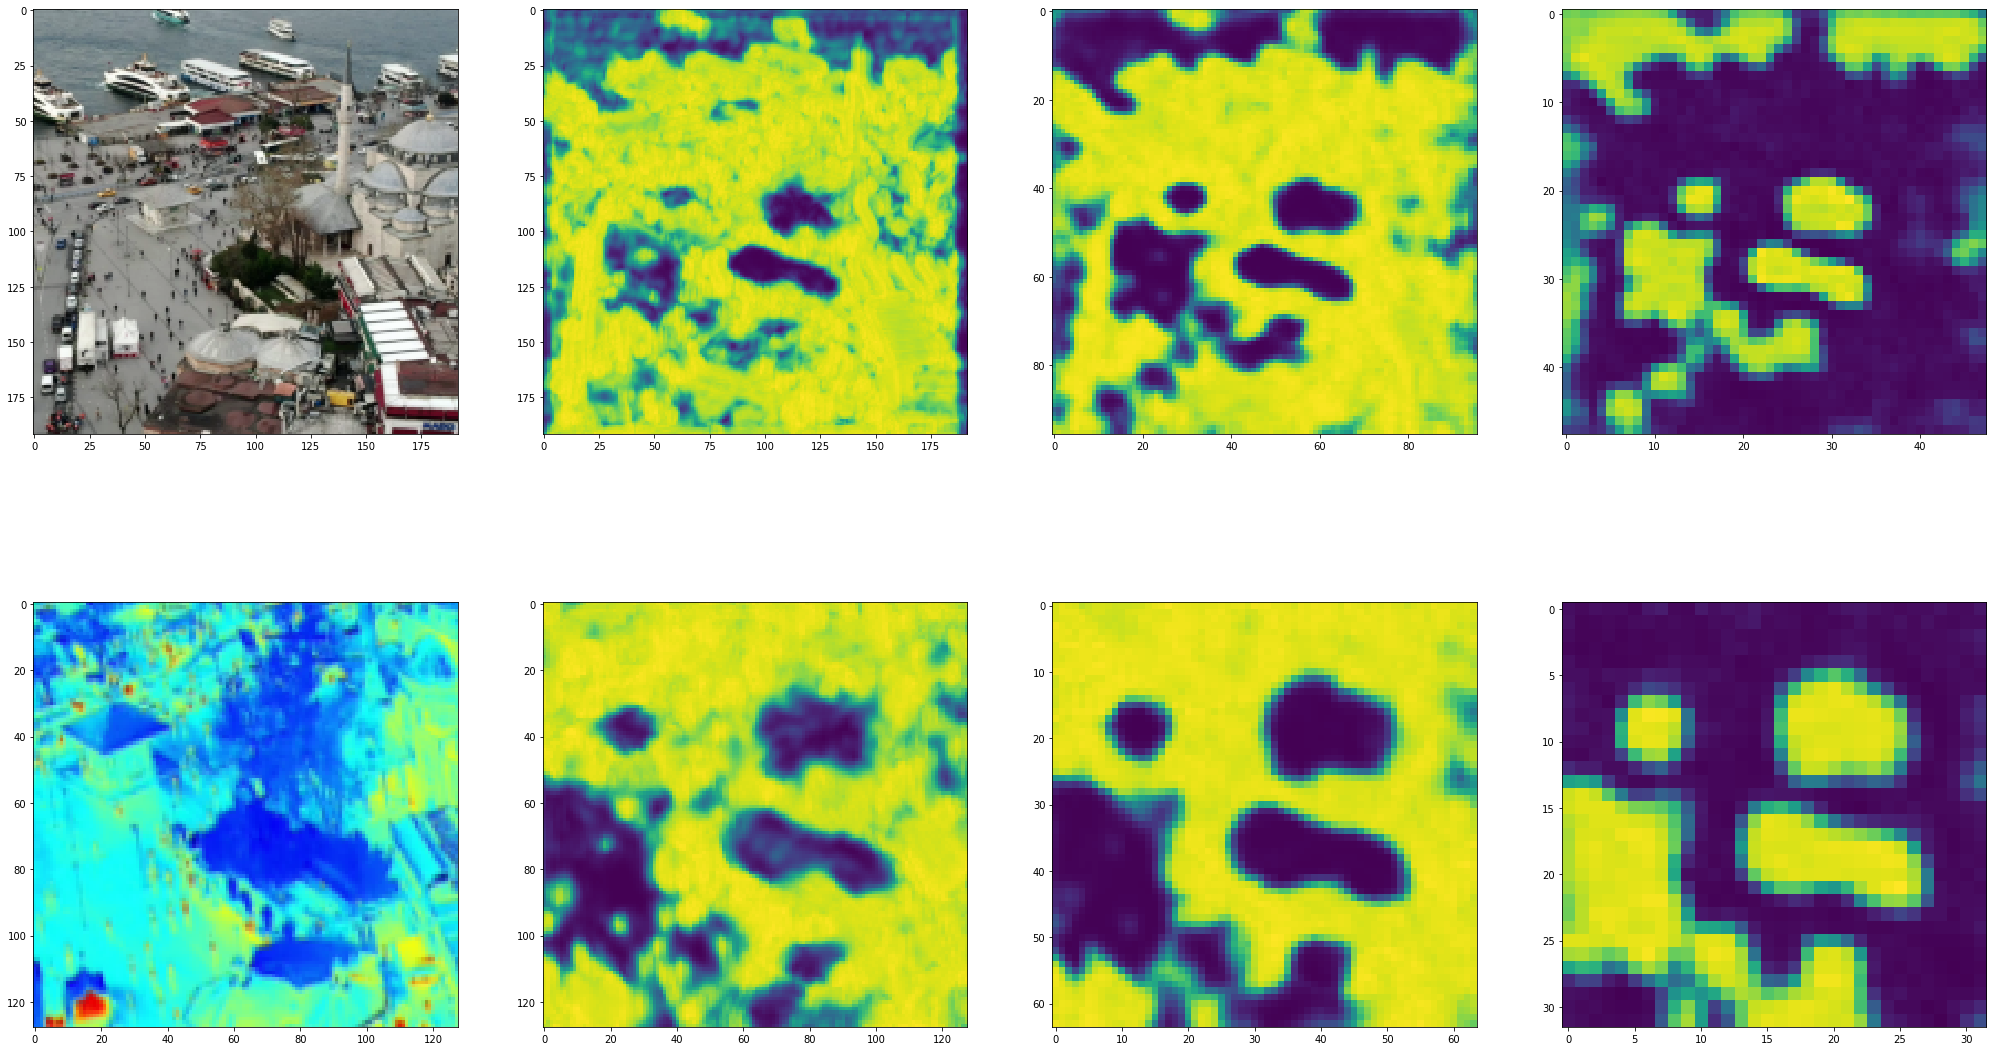

In [15]:
fig, axe = plt.subplots(2, 4, figsize=(35,20))

axe[0][0].imshow(input_img[0,:,:,:3])
axe[0][1].imshow(input_feature_map_one[0,:,:,0])
axe[0][2].imshow(input_feature_map_two[0,:,:,0])
axe[0][3].imshow(input_feature_map_three[0,:,:,0])

axe[1][0].imshow(template_img[0,:,:,:3])
axe[1][1].imshow(template_feature_map_one[0,:,:,0])
axe[1][2].imshow(template_feature_map_two[0,:,:,0])
axe[1][3].imshow(template_feature_map_three[0,:,:,0])




plt.show()
plt.close()

In [16]:
predicted_matrix

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[ 9.3849206e-01, -1.0328446e-01,  3.9246880e+01],
        [ 1.3612582e-02,  8.0318165e-01,  5.4388020e+01],
        [-5.4099708e-04,  3.1139510e-04,  1.0000000e+00]]], dtype=float32)>